# SWE Reanalysis EOF and K-Means Clustering

In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import contextily as ctx
import ulmo
import datetime as dt
from datetime import datetime
from shapely.geometry import Point
import metloom
from metloom.pointdata import CDECPointData
from metloom.pointdata import SnotelPointData
from metloom.variables import CdecStationVariables
import pickle
import scipy.stats as stats
# SVD function from scipy
from scipy.linalg import svd
import sklearn
from sklearn.cluster import KMeans

import rioxarray as rxr
import xarray as xr

In [2]:
wstates = gpd.read_file('../data/misc/western_states.shp')
wstates_4326=wstates.to_crs('epsg:4326')

wstates_boundary = gpd.read_file('../data/misc/western_boundary.geojson')

station_locations_co = pickle.load(open('../data/station_locations_co.pkl', 'rb'))
combined_april1_anom_co = pickle.load(open('../data/combined_april1_anom_co.pkl', 'rb'))

In [3]:
base_dir = '../data/reanalysis/' 
fname_lst = []
## create list of netcdf files ##
years = list(sorted((f for f in os.listdir(base_dir) if not f.startswith(".")), key=str.lower))
for year in years:
    yr_dir = f'{base_dir}{year}/'
    fname = os.listdir(yr_dir)[0]
    fname_lst.append(f'{base_dir}{year}/{fname}')
## load netcdf ##
def preprocess(ds):
    ds['SD_Post'] = ds['SD_Post'].T
    ## set spatial reference ##
    ds.rio.write_crs('EPSG:4326',inplace = True)
    ds = ds.rename({'Latitude':'y','Longitude':'x'})
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)
    return ds
    # ds.expand_dims(dim = 'Year')
    
## load files and concatenate by Year ##
ds = xr.open_mfdataset(fname_lst, concat_dim = 'Year',combine = 'nested', preprocess = preprocess)
## rename years ##
ds['Year'] = np.arange(1990,2022)
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 32)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Data variables:
    SD_Post      (Year, y, x) float32 dask.array<chunksize=(1, 4050, 5175), meta=np.ndarray>

In [4]:
anomalies = ds.SD_Post - ds.SD_Post.mean(dim='Year')

In [5]:
anomalies_sdev = anomalies / ds.SD_Post.std(dim='Year')

In [8]:
anomalies

<xarray.DataArray 'SD_Post' (Year: 32, y: 4050, x: 5175)>
dask.array<sub, shape=(32, 4050, 5175), dtype=float32, chunksize=(1, 4050, 5175), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021

In [9]:
anomalies_sdev

<xarray.DataArray 'SD_Post' (Year: 32, y: 4050, x: 5175)>
dask.array<truediv, shape=(32, 4050, 5175), dtype=float32, chunksize=(1, 4050, 5175), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021

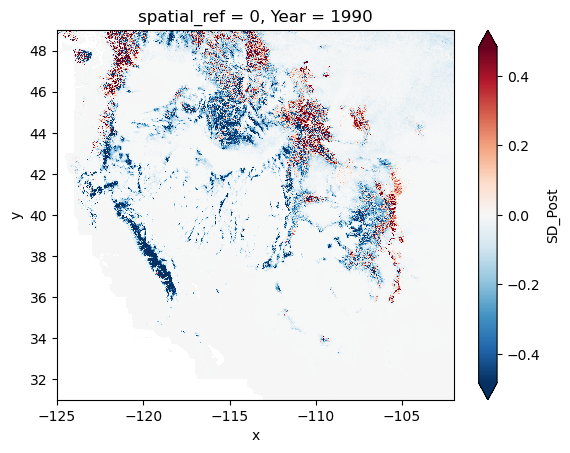

In [10]:
anomalies[0].plot(robust=True)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


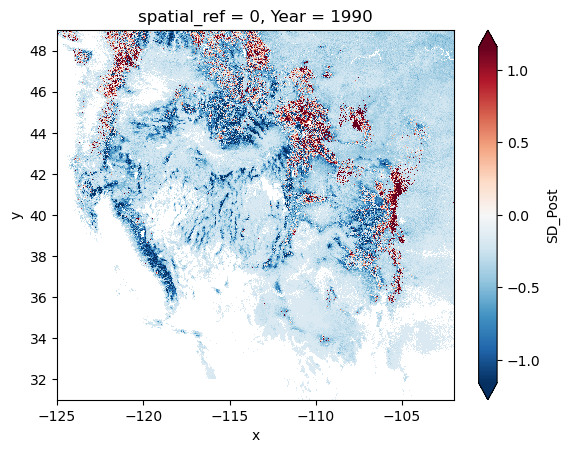

In [11]:
anomalies_sdev[0].plot(robust=True) 

Because of the issue with dividing by 0, I will start by just using the anomalies, instead of the anomaly divided by standard deviation.

In [12]:
anomalies.rio.crs

CRS.from_epsg(4326)

In [6]:
colorado = wstates[wstates['NAME'] == 'Colorado'].to_crs('epsg:4326')
colorado.bounds

minx       miny        maxx       maxy
2 -109.060253  36.992426 -102.041524  41.003444

In [7]:
min_lon = -109.060253
min_lat = 36.992426
max_lon = -104
max_lat = 41.003444

subset = anomalies.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)

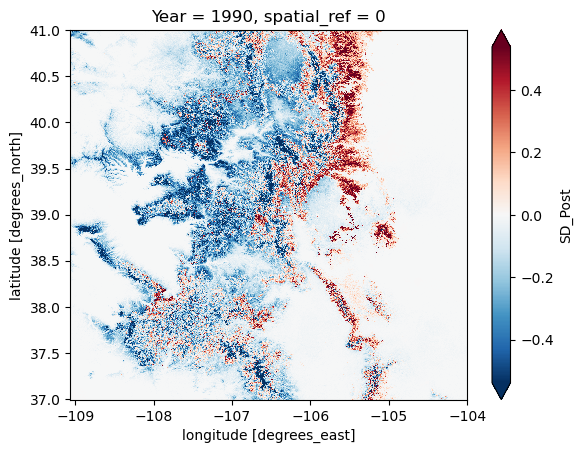

In [11]:
subset[0].plot(robust=True)

In [8]:
subset_years = subset[15:32,:,:]

In [141]:
subset

<xarray.DataArray 'SD_Post' (Year: 32, y: 903, x: 1580)>
dask.array<getitem, shape=(32, 903, 1580), dtype=float32, chunksize=(1, 903, 1580), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 36.99 37.0 37.0 37.01 ... 40.99 40.99 41.0 41.0
  * x            (x) float64 -109.1 -109.1 -109.1 ... -102.1 -102.0 -102.0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 0

In [9]:
flattened_subset = subset_years.stack(z=('x','y'))
flattened_subset

<xarray.DataArray 'SD_Post' (Year: 17, z: 1028517)>
dask.array<reshape, shape=(17, 1028517), dtype=float32, chunksize=(1, 1028517), chunktype=numpy.ndarray>
Coordinates:
  * Year         (Year) int64 2005 2006 2007 2008 2009 ... 2018 2019 2020 2021
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * x            (z) float64 -109.1 -109.1 -109.1 ... -104.0 -104.0 -104.0
  * y            (z) float64 36.99 37.0 37.0 37.01 ... 40.99 40.99 41.0 41.0

In [16]:
flattened_anomalies = anomalies.stack(z=('x','y'))

In [105]:
# Perform the SVD

# perform svd analysis on swe reanalysis data
Ur, Sr, Vr = svd(flattened_subset.T,full_matrices=False)

In [115]:
Ur.shape

(1426740, 17)

In [106]:
combined_april1_anom_co

303_CO_SNTL  1030_CO_SNTL  1061_CO_SNTL  327_CO_SNTL  \
2005-04-01        34.76      8.761905      1.894737    36.608696   
2006-04-01        -9.24      9.761905      4.894737     9.608696   
2007-04-01        -1.24     -3.238095     -0.105263    -9.391304   
2008-04-01        17.76     11.761905      5.894737    19.608696   
2009-04-01         2.76      1.761905      1.894737    -1.391304   
2010-04-01        19.76    -11.238095     -1.105263     6.608696   
2011-04-01        -8.24     25.761905     12.894737     2.608696   
2012-04-01        -3.24    -25.238095    -15.105263   -24.391304   
2013-04-01       -10.24    -10.238095     -7.105263   -14.391304   
2014-04-01       -14.24     20.761905      9.894737    -1.391304   
2015-04-01       -14.24    -18.238095     -5.105263   -27.391304   
2016-04-01        -7.24     18.761905      3.894737   -11.391304   
2017-04-01         9.76     -1.238095    -12.105263     1.608696   
2018-04-01       -14.24     -2.238095     -4.105263   -26.391304   
2019-04-01        17.76      9.761905      4.894737    35.608696   
2020-04-01       -11.24      5.761905      2.894737     7.608696   
2021-04-01         4.76     -1.238095     -4.105263    -0.391304   
2022-04-01         2.76     -3.238095     -9.105263    -1.391304   
2023-04-01        -9.24     22.761905      8.894737    33.608696   

            1041_CO_SNTL  335_CO_SNTL  345_CO_SNTL  369_CO_SNTL  938_CO_SNTL  \
2005-04-01          7.45    -0.285714    22.730769         0.15     0.583333   
2006-04-01          4.45     7.714286    18.730769         3.15     2.583333   
2007-04-01         -9.55     2.714286    -6.269231        -5.85     1.583333   
2008-04-01         18.45    15.714286    22.730769        15.15     9.583333   
2009-04-01         11.45     6.714286    12.730769         6.15     2.583333   
2010-04-01         -7.55    -5.285714    -2.269231        -0.85    -2.416667   
2011-04-01          9.45    17.714286    34.730769        11.15     9.583333   
2012-04-01        -22.55   -38.285714   -23.269231       -20.85   -15.416667   
2013-04-01         -4.55    -7.285714   -16.269231       -12.85    -8.416667   
2014-04-01         10.45    15.714286     5.730769        10.15     6.583333   
2015-04-01        -13.55   -15.285714   -24.269231        -9.85    -6.416667   
2016-04-01          4.45    17.714286    -5.269231         6.15     4.583333   
2017-04-01        -13.55   -12.285714    -0.269231        -2.85     0.583333   
2018-04-01        -10.55   -10.285714   -15.269231        -8.85    -7.416667   
2019-04-01         12.45     7.714286    18.730769        13.15    19.583333   
2020-04-01          5.45     6.714286    -6.269231         8.15     8.583333   
2021-04-01         -2.55     2.714286    -8.269231         5.15    -4.416667   
2022-04-01         -0.55    -9.285714    -7.269231        -4.85    -7.416667   
2023-04-01         17.45     7.714286    45.730769        11.15    -3.416667   

            913_CO_SNTL  ...  802_CO_SNTL  827_CO_SNTL  839_CO_SNTL  \
2005-04-01         -5.0  ...         7.05     15.47619    15.684211   
2006-04-01          9.0  ...        10.05     24.47619    -4.315789   
2007-04-01        -14.0  ...        -1.95      5.47619   -13.315789   
2008-04-01          3.0  ...        21.05     24.47619    14.684211   
2009-04-01          3.0  ...         7.05     25.47619    -7.315789   
2010-04-01        -14.0  ...       -11.95      4.47619     9.684211   
2011-04-01         18.0  ...        15.05     25.47619    -9.315789   
2012-04-01        -11.0  ...       -27.95    -25.52381   -13.315789   
2013-04-01         -3.0  ...        -4.95     -1.52381    -9.315789   
2014-04-01         23.0  ...         9.05     11.47619     0.684211   
2015-04-01         -5.0  ...       -13.95     -8.52381   -14.315789   
2016-04-01         11.0  ...         8.05      8.47619     2.684211   
2017-04-01         -9.0  ...        -6.95    -36.52381    -4.315789   
2018-04-01          4.0  ...       -11.95    -28.52381  

In [107]:
combined_april1_anom_co_years = combined_april1_anom_co[:-2]

In [113]:
# for comparison

combined_april1_anom_co_years_array = combined_april1_anom_co_years.to_numpy()

In [114]:
Uco, Sco, Vco = svd(combined_april1_anom_co_years_array.T,full_matrices=False)

In [116]:
# SVD Variance Explained, divide S values by the sum of all S
var_exp = Sr / np.sum(Sr)

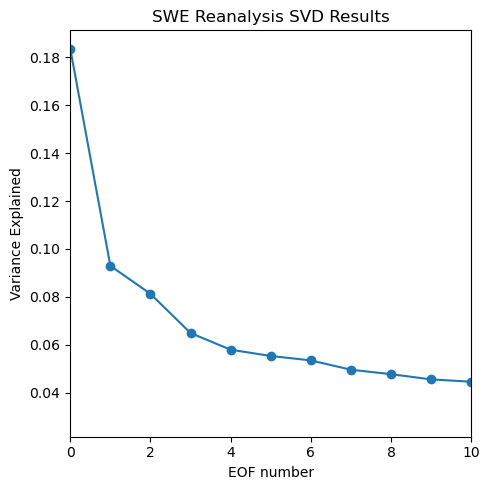

In [117]:
plt.figure(figsize=(5,5))
plt.plot(var_exp,'-o')
plt.xlabel('EOF number')
plt.ylabel('Variance Explained')
#plt.title('SVD Variance Explained')
#plt.ylim([0,0.16])
plt.xlim([0,10])
plt.title('SWE Reanalysis SVD Results')
plt.tight_layout()
plt.savefig('../figures/91823/reanalysis_eof_varianceexplained.jpeg');

In [118]:
# the first 10:
#print(var_exp[0:10])

# sum of the first 10
print('Percent of overall variance explained by \nthe top 10 patterns = {}%'.format( np.round( 100*np.sum(var_exp[0:10]),1)), '\nthe top 4 patterns = {}%'.format( np.round( 100*np.sum(var_exp[0:4]),1)))

Percent of overall variance explained by 
the top 10 patterns = 73.2% 
the top 4 patterns = 42.3%


In [119]:
Ur.shape

(1426740, 17)

In [120]:
Ur_t = Ur.T
Vr_t = Vr.T
print(Ur_t.shape)
print(Vr_t.shape)

(17, 1426740)
(17, 17)


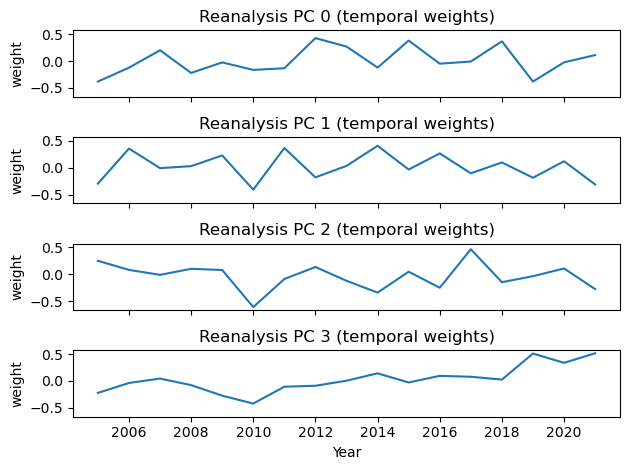

In [129]:
#Plot first PC (V)
f, ax = plt.subplots(4,1, sharex=True, sharey=True)
i=0
for row in range(4): 
    ax[row].plot(np.linspace(2005, 2021, num=17, dtype=int),Vr[i,:])
    ax[row].set_ylabel('weight')
    ax[row].set_title(f'Reanalysis PC {i} (temporal weights)')
    i+=1
ax[3].set_xlabel('Year')
plt.tight_layout()
plt.savefig('../figures/91823/reanalysis_pc_plots.jpeg')

In [25]:
subset.shape

(32, 903, 1580)

In [122]:
# dims: [time, y, x] 

Ur_t_reshaped = Ur_t.reshape(
        subset_years.shape[0], subset_years.shape[1], subset_years.shape[2]
    )

In [31]:
np.linspace(1, 32, num=32, dtype=int)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [125]:
Ur_t_reshaped = Ur_t.reshape(
        subset_years.shape[0], subset_years.shape[2], subset_years.shape[1]
    )

Ur_dataArray = xr.DataArray(data = Ur_t_reshaped,
                           dims=("EOF","x","y"),
                           coords=[np.linspace(1, 17, num=17, dtype=int),subset_years.x,subset_years.y])

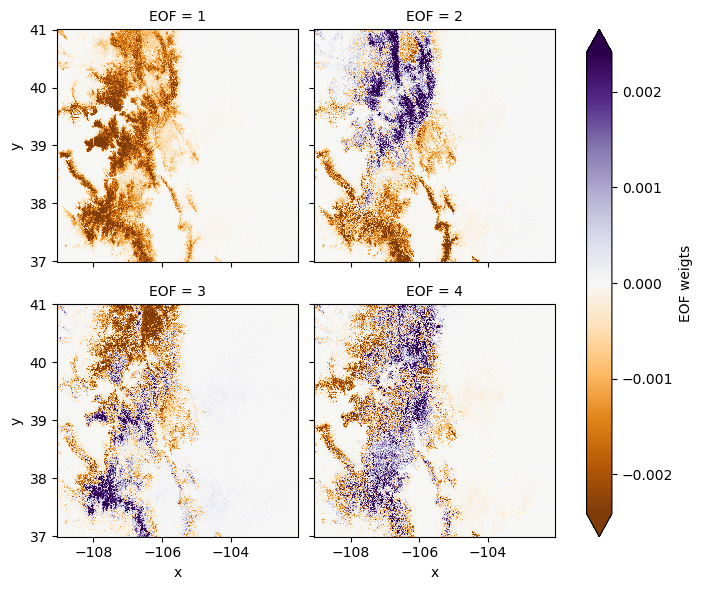

In [126]:
firstFour = Ur_dataArray.isel(EOF=slice(0, 4)).copy()

g = firstFour.plot.pcolormesh(
    x="x",
    y="y",
    col="EOF",
    col_wrap=2,
    robust=True,
    cmap="PuOr",
    cbar_kwargs={"label": "EOF weigts"},
)
plt.savefig('../figures/91823/reanalysis_eof_plots.jpeg')

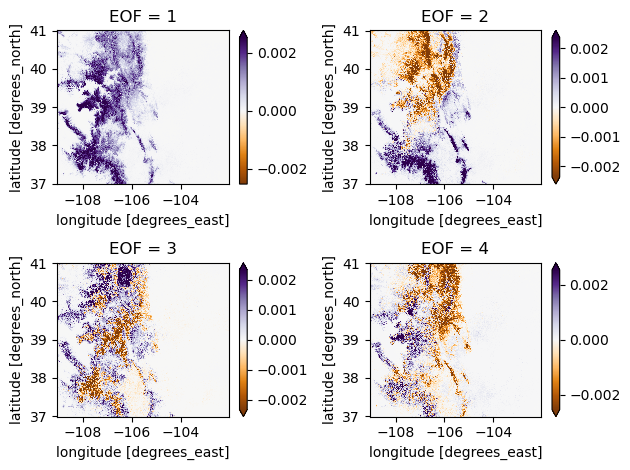

In [65]:
f, ax = plt.subplots(2,2)
i = 0
for row in range(2):
    for column in range(2):
        Ur_dataArray[i].T.plot(ax=ax[row,column], robust=True, cmap='PuOr')
        i+=1
plt.tight_layout()
plt.savefig('../figures/91823/reanalysis_eof_plots.jpeg')

type: 'Axes' object is not subscriptable

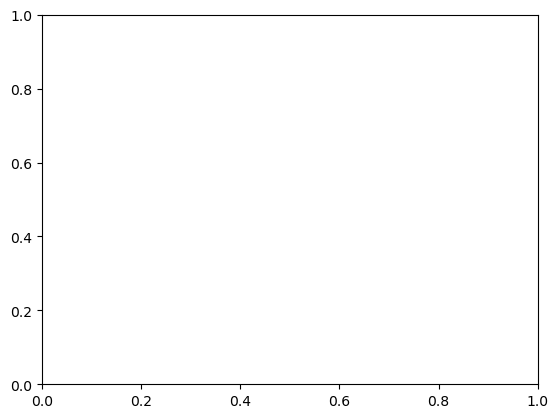

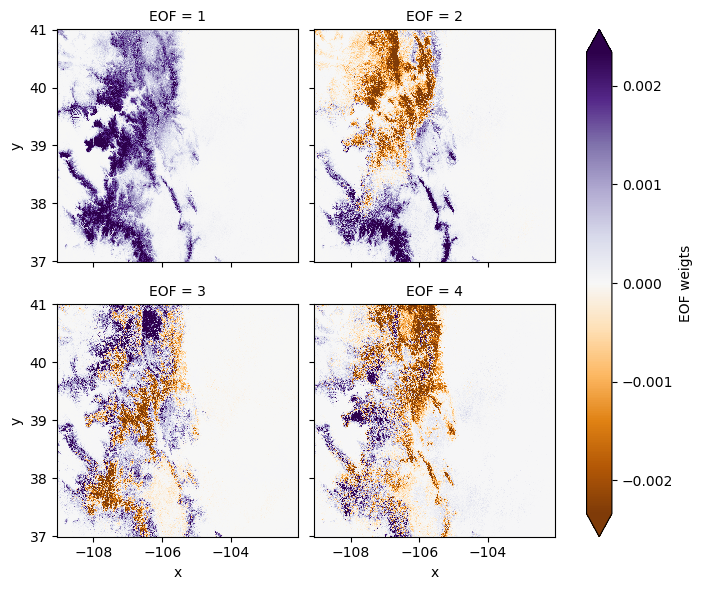

In [73]:
firstFour = Ur_dataArray.isel(EOF=slice(0, 4)).copy()

fig, ax = plt.subplots()
g = firstFour.plot.pcolormesh(
    x="x",
    y="y",
    col="EOF",
    col_wrap=2,
    robust=True,
    cmap="PuOr",
    cbar_kwargs={"label": "EOF weigts"},
)
i = 0
for row in range(2):
    for column in range(2):
        Ur_dataArray[i].T.plot(ax=ax[row,column], robust=True, cmap='PuOr')
        station_locations_co.plot(ax=ax[row,column], column=Uco[:,i], legend=False, cmap='PuOr', vmin=-0.16, vmax=0.16, markersize=3,marker='o')
        i+=1

In [74]:
import seaborn as sns

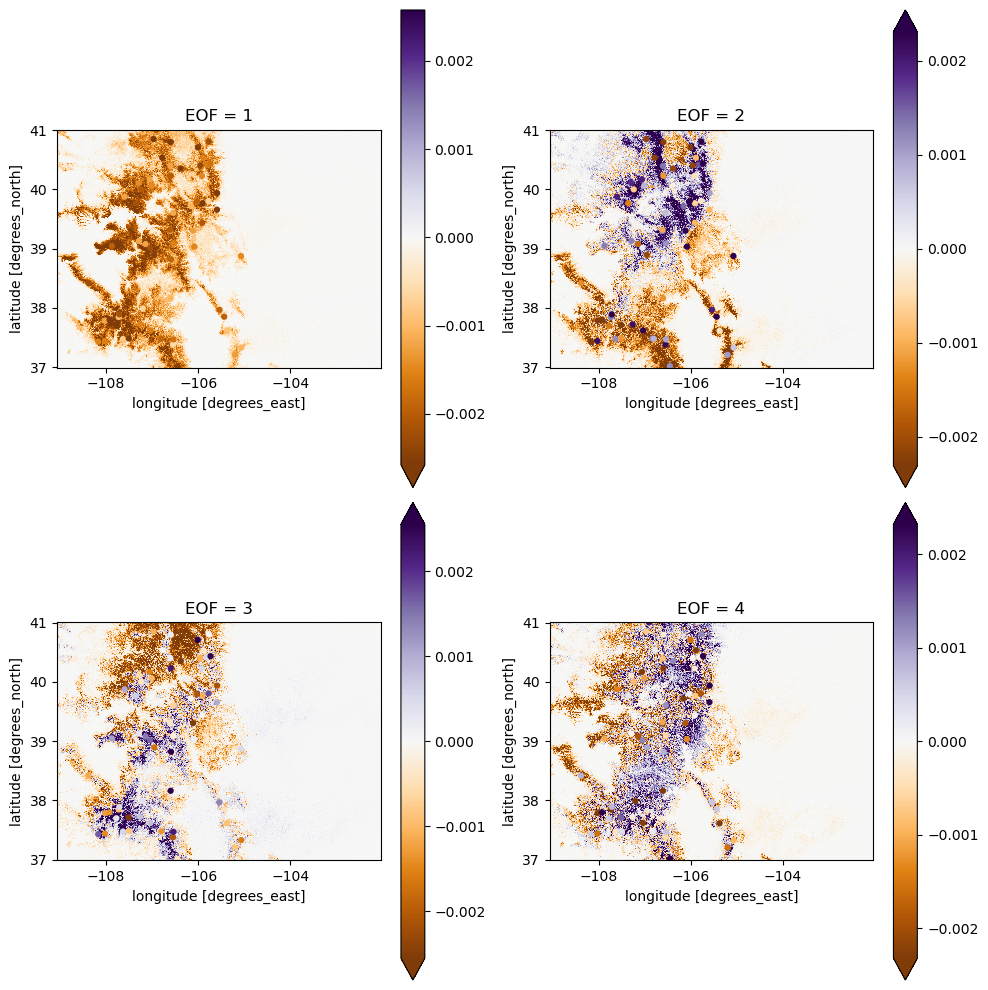

In [130]:
f, ax = plt.subplots(2,2,figsize=(10,10))
i = 0
for row in range(2):
    for column in range(2):
        Ur_dataArray[i].T.plot(ax=ax[row,column], robust=True, cmap='PuOr')
        station_locations_co.plot(ax=ax[row,column], column=Uco[:,i], legend=False, cmap='PuOr', vmin=-0.16, vmax=0.16, markersize=12,marker='o')
        i+=1
#sns.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('../figures/91823/reanalysis_station_eof_plots.jpeg')

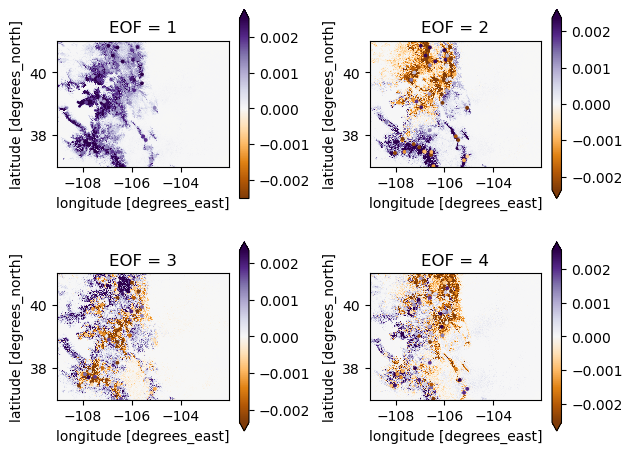

In [64]:
f, ax = plt.subplots(2,2)
i = 0
for row in range(2):
    for column in range(2):
        Ur_dataArray[i].T.plot(ax=ax[row,column], robust=True, cmap='PuOr')
        station_locations_co.plot(ax=ax[row,column], column=Uco[:,i], legend=False, cmap='PuOr_r', vmin=-0.16, vmax=0.16, markersize=3,marker='o')

        # ax[row,column].set_xlim(-109.2,-102.5)
        # ax[row,column].set_ylim(36.7,41.2)
        # ctx.add_basemap(ax=ax[row,column], crs='epsg:4326', source=ctx.providers.Stamen.Terrain, attribution=False)
        # colorado.plot(ax=ax[row,column], facecolor='none', edgecolor='k')
        # ax[row,column].set_title('EOF {}'.format(i+1))
        # ax[row,column].set_xlabel('Longitude')
        # ax[row,column].set_ylabel('Latitude')
        i+=1
plt.tight_layout()
#plt.savefig('../figures/91823/station_eof_plots.jpeg')

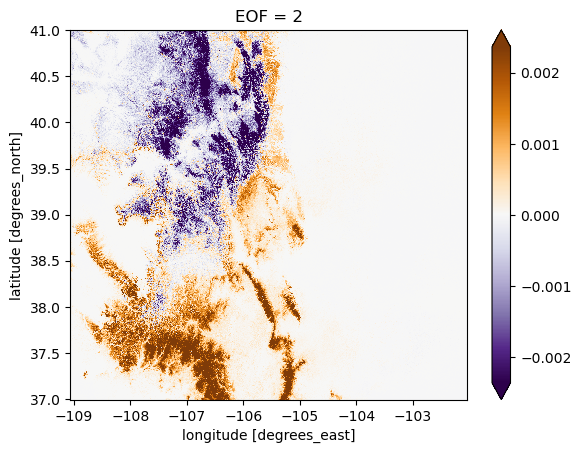

In [36]:
Ur_dataArray[1].T.plot(robust=True, cmap='PuOr_r')

In [131]:
# Perform the SVD on entire western US

# perform svd analysis on swe reanalysis data
#Ura, Sra, Vra = svd(flattened_anomalies.T,full_matrices=False)

Need to deal with nan values inherent to nonrectangular data

## K-means Clustering analysis

In [15]:
flattened_subset.shape

(17, 1028517)

In [10]:
np.corrcoef?

Signature:
np.corrcoef(
    x,
    y=None,
    rowvar=True,
    bias=<no value>,
    ddof=<no value>,
    *,
    dtype=None,
)
Docstring:
Return Pearson product-moment correlation coefficients.

Please refer to the documentation for `cov` for more detail.  The
relationship between the correlation coefficient matrix, `R`, and the
covariance matrix, `C`, is

.. math:: R_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} C_{jj} } }

The values of `R` are between -1 and 1, inclusive.

Parameters
----------
x : array_like
    A 1-D or 2-D array containing multiple variables and observations.
    Each row of `x` represents a variable, and each column a single
    observation of all those variables. Also see `rowvar` below.
y : array_like, optional
    An additional set of variables and observations. `y` has the same
    shape as `x`.
rowvar : bool, optional
    If `rowvar` is True (default), then each row represents a
    variable, with observations in the columns. Otherwise, the relationship
    is tra

In [ ]:
pearsons_cc = np.corrcoef(flattened_subset.T)

In [12]:
pearsons_cc.shape

(17, 17)

Too much data - corrcoef makes a matrix with square dimensions equal to the longer side. This is currently the filter point for this analysis. Need to figure out how to streamline this. Some ideas include:  
* Dask
* Linux box
* manually chunk data - does this result in edge effects?